# Simultaneous Quantiles

---

---

### Overview

This notebook trains two variations of models which can be used to estimate aleatoric uncertainty.  The first does not include any additional monotonic features, and the second does.

A special loss function is used that allows us to predict any quantile with a single training step, and to change that quantile arbitrarily, without requiring retraining.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from tabularasa.SimultaneousQuantiles import SimultaneousQuantilesRegressor, SimultaneousQuantilesNet, SimultaneousQuantilesMixedMonotonicNet

---

### Load example data

If you haven't already, please generate the example dataset using the [example_data](example_data.ipynb) notebook.

In [3]:
df = pd.read_pickle('./examples/data/simple_train.pkl')

---

### Train a model without monotonicity constraints

We'll

In [4]:
class EmbeddingNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.emb1 = nn.Embedding(50, 16)
        self.fc1 = nn.Linear(1 + 16, 16)
    
    def forward(self, X_non_monotonic):
        X = torch.cat([X_non_monotonic[:, 1, None].float(), 
                       self.emb1(X_non_monotonic[:, 0, None].long()).squeeze()], 1)
        return F.relu(self.fc1(X))

In [5]:
model = SimultaneousQuantileRegressor(SimultaneousQuantileMixedMonotonicNet,
                           max_epochs=25,
                           lr=0.001,
                           optimizer=torch.optim.Adam,
                           module__non_monotonic_net=EmbeddingNet(),
                           module__dim_non_monotonic=16,
                           module__dim_monotonic=2,
                           module__layers=[128, 128, 32],
                           module__integration_steps=300)

In [6]:
model.fit({'X_monotonic': df[['x1', 'x2']].values,
           'X_non_monotonic': df[['x3', 'x4']].values},
          df[['y']].values)

  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1        0.5811        0.4595  10.3075
      2        0.3487        0.2315  9.4292
      3        0.2238        0.2295  9.2418
      4        0.2224        0.1868  9.2474
      5        0.2035        0.2347  9.2152
      6        0.2024        0.1963  8.7851
      7        0.2000        0.2031  8.8613
      8        0.2014        0.1922  8.8707
      9        0.1924        0.2000  9.0655
     10        0.1878        0.1973  8.9809
     11        0.1982        0.1897  8.9462
     12        0.1923        0.2135  8.8839
     13        0.1925        0.1929  8.7842


<class 'tabularasa.SimultaneousQuantileRegressor.SimultaneousQuantileRegressor'>[initialized](
  module_=SimultaneousQuantileMixedMonotonicNet(
    (non_monotonic_net): EmbeddingNet(
      (emb1): Embedding(50, 16)
      (fc1): Linear(in_features=17, out_features=16, bias=True)
    )
    (umnn): SlowDMonotonicNN(
      (outer_net): MonotonicNN(
        (integrand): IntegrandNN(
          (inner_net): Sequential(
            (0): Linear(in_features=17, out_features=128, bias=True)
            (1): ReLU()
            (2): Linear(in_features=128, out_features=128, bias=True)
            (3): ReLU()
            (4): Linear(in_features=128, out_features=32, bias=True)
            (5): ReLU()
          )
          (net): Sequential(
            (0): Linear(in_features=17, out_features=128, bias=True)
            (1): ReLU()
            (2): Linear(in_features=128, out_features=128, bias=True)
            (3): ReLU()
            (4): Linear(in_features=128, out_features=32, bias=True)
       

In [7]:
quantiles = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]

In [8]:
results = []
for q in np.quantile(df['x1'], quantiles):
    dfc = df.copy()
    dfc['x1'] = q
    dfc['x1'] = dfc['x1'].astype('float32')
    p = model.predict({'X_monotonic': dfc[['x1', 'x2']].values,
                       'X_non_monotonic': dfc[['x3', 'x4']].values})
    p = pd.DataFrame(pd.Series(p[:, 0]).describe(percentiles=quantiles)).T
    p['x1'] = q
    results.append(p)
results = pd.concat(results, axis=0)

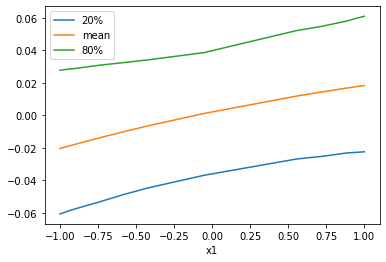

In [9]:
results.plot(x='x1', y=['20%', 'mean', '80%'])
plt.show()

In [10]:
model.predict({'X_monotonic': df[['x1', 'x2']].values,
               'X_non_monotonic': df[['x3', 'x4']].values})

array([[-0.00588573],
       [ 0.04773763],
       [ 0.06194977],
       ...,
       [ 0.0665164 ],
       [ 0.07168144],
       [ 0.06724489]], dtype=float32)

In [11]:
model.predict({'X_monotonic': df[['x1', 'x2']].values,
               'X_non_monotonic': df[['x3', 'x4']].values}, q=0.5)

array([[-0.00588573],
       [ 0.04773763],
       [ 0.06194977],
       ...,
       [ 0.0665164 ],
       [ 0.07168144],
       [ 0.06724489]], dtype=float32)

In [12]:
model.predict({'X_monotonic': df[['x1', 'x2']].values,
               'X_non_monotonic': df[['x3', 'x4']].values}, q=0.9)

array([[2.5714515e-05],
       [4.9877182e-02],
       [6.4310715e-02],
       ...,
       [6.8276986e-02],
       [7.3422000e-02],
       [6.8904407e-02]], dtype=float32)

In [13]:
model.predict({'X_monotonic': df[['x1', 'x2']].values,
               'X_non_monotonic': df[['x3', 'x4']].values}, q=0.1)

array([[-0.0120576 ],
       [ 0.04543061],
       [ 0.05940571],
       ...,
       [ 0.06460671],
       [ 0.06979516],
       [ 0.06544493]], dtype=float32)

In [14]:
model.predict({'X_monotonic': df[['x1', 'x2']].values,
               'X_non_monotonic': df[['x3', 'x4']].values}, q=0.5, last_hidden_layer=True)

array([[1.8008924, 1.       , 1.8807808, ..., 2.6754327, 1.8818873,
        1.       ],
       [2.2934756, 1.       , 2.3940916, ..., 3.5926368, 2.3543181,
        1.       ],
       [2.2879782, 1.       , 2.372876 , ..., 3.5557475, 2.3435197,
        1.       ],
       ...,
       [2.653592 , 1.       , 2.5795307, ..., 4.14019  , 2.5826511,
        1.       ],
       [2.661717 , 1.       , 2.590844 , ..., 4.161422 , 2.5904365,
        1.       ],
       [2.6822915, 1.       , 2.604792 , ..., 4.198989 , 2.6081073,
        1.       ]], dtype=float32)

### Estimate epistemic uncertainty via orthonormal certificates

Start by prepping data from the inner hidden layer.

In [9]:
model.module_.set_last_layer(inner=True)

In [21]:
X_inner = model.predict({'X_monotonic': df[['x1', 'x2']].values,
                         'X_non_monotonic': df[['x3', 'x4']].values})

Now train orthonormal certificates.  Note, including raw numeric features helps quality.

In [24]:
oc = OrthonormalCertificates()
oc.fit(np.concatenate([df[['x1', 'x2', 'x4']].values, X_inner], axis=1))

Create another PDP like dataset with the full range.

In [31]:
uncertainties = []
for q in np.linspace(-1.5, 1.5, 101):
    dfc = df.copy()
    dfc['x1'] = q
    dfc['x1'] = dfc['x1'].astype('float32')
    p = oc.transform(np.concatenate([dfc[['x1', 'x2', 'x4']],
                                     model.predict({'X_monotonic': dfc[['x1', 'x2']].values,
                                                    'X_non_monotonic': dfc[['x3', 'x4']].values})], axis=1))
    p = pd.DataFrame(pd.Series(p).describe(percentiles=quantiles)).T
    p['x1'] = q
    uncertainties.append(p)
uncertainties = pd.concat(uncertainties, axis=0)

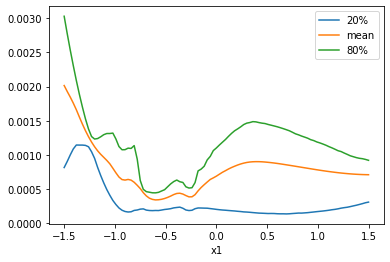

In [32]:
uncertainties.plot(x='x1', y=['20%', 'mean', '80%'])
plt.show()

Epistemic uncertainty is high below -1 (where training data starts and is relatively low), decreases between -1 and 0, picks back up between 0 and 0.5, and then decreases between 0.5 and 1.  After 1, it doesn't perform exactly as desired, but is ticking up in some places.